### CSCI E-82  Homework 3

### Due by 10/22/18 at 11:59pm EST to the Canvas dropbox

## This is an individual homework so there should be no collaboration for this homework.


### Under each problem, we have a place for you to write the answer, or write runnable code that will produce the answer.  Show your work.
-----------


## Your Name: 

Paul Washburn

## Problem 1 Climate Change (30 points) 

Scientists and politicians are often at odds on the topic of whether global warming is real and debate the various causes. This problem uses "globalWarm3.csv" data.  This is a real data set.

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot as plt
from yellowbrick.regressor import ResidualsPlot
import statsmodels.tsa.api as smt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [88]:
# read in gw data
gw = pd.read_csv('data/globalWarm3.csv')
gw.set_index('Year', inplace=True)

# get log 
gw['log_temp'] = np.log(gw.Temp)

# fill na
not_missing = ~gw.Transmission.isnull()
gw.loc[~not_missing, 'Transmission'] = gw.loc[not_missing, 'Transmission'].mean()

gw.head()

,Temp,CO2,Solar,Transmission,IceShelf,log_temp
Year,,,,,,
1980,19,338.57,1366.51,0.929667,7.85,2.944439
1981,26,339.92,1366.51,0.929767,7.25,3.258097
1982,4,341.30,1366.16,0.853067,7.45,1.386294
1983,25,342.71,1366.18,0.897717,7.52,3.218876
1984,9,344.24,1365.71,0.916492,7.17,2.197225


### Problem 1a 
Plot a scatter plot of the following variables in a lattice: Temp, CO2, Solar, Transmission, and IceShelf. 
    
The variables represent the following:
- Temp = annual surface temperature measured in $1/100^{\circ} C$ over the 1950-1980 mean.
- Solar = annual mean intensity of sunlight piercing the atmosphere 
- CO2 = annual average fraction CO2 in atmosphere (#molecules/#molecules of dry air) 
- IceShelf = sea ice in 1MM square miles hypothesized to reflect heat 
- Transmission = volcanic MLO transmission data where eruptions release greenhouse gases but also decrease the temperature 




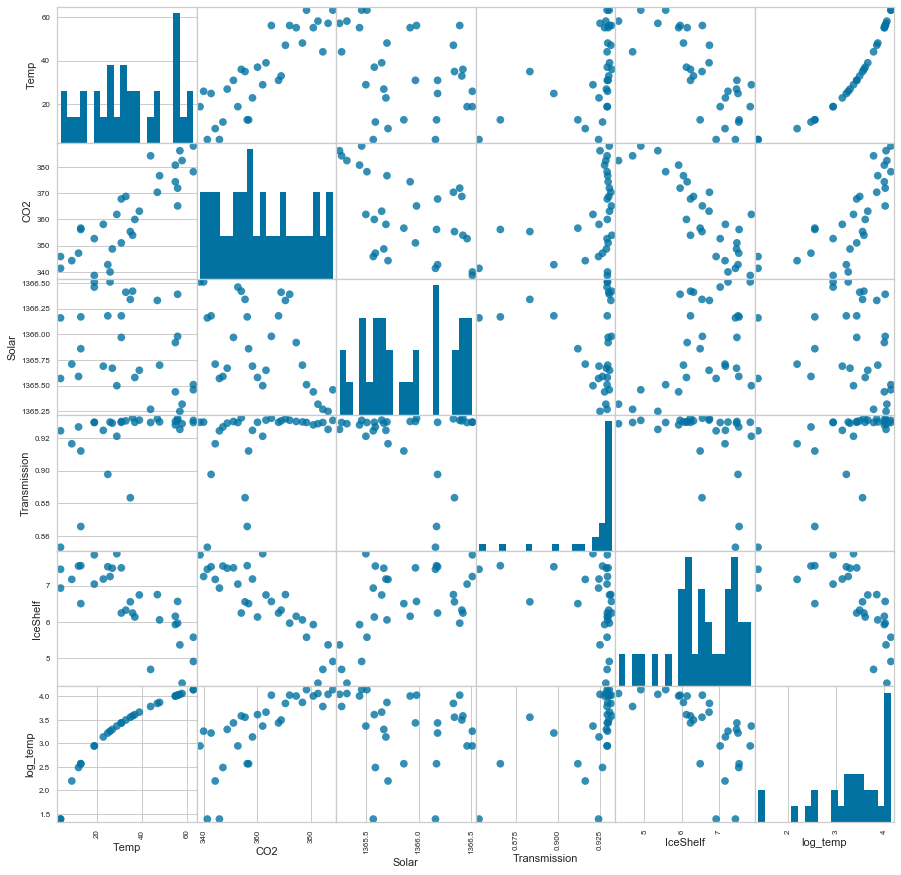

In [89]:
pd.plotting.scatter_matrix(gw, figsize=(15, 15), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8)
plt.show()

### Problem 1b 
Compute a multiple linear regression model of log(Temp) against the other variables. Note that since there are limited number of annual measurements, you cannot run all combinations of variables. In fact, you can only do complete pairwise interactions. Be sure to remove the non-significant variables while still maintaining the hierarchy principle in your final model. You do not need to show full diagnostics for the different models that you try, but do show the equations that you tried.

#### Isolate `X` & `y` and Add Interaction Terms

In [90]:
X_cols = ['CO2', 'Solar', 'Transmission', 'IceShelf']
X, y = gw[X_cols], gw['log_temp']

# fit polynomial features
poly = PolynomialFeatures(2, include_bias=False)
poly.fit(X)
X = pd.DataFrame(poly.transform(X), columns=poly.get_feature_names(X.columns))

# preview
X.head()

,CO2,Solar,Transmission,IceShelf,CO2^2,CO2 Solar,CO2 Transmission,CO2 IceShelf,Solar^2,Solar Transmission,Solar IceShelf,Transmission^2,Transmission IceShelf,IceShelf^2
0,338.57,1366.51,0.929667,7.85,114629.6449,462659.2907,314.757243,2657.7745,1.867350e+06,1270.398797,10727.1035,0.864280,7.297883,61.6225
1,339.92,1366.51,0.929767,7.25,115545.6064,464504.0792,316.046285,2464.4200,1.867350e+06,1270.535448,9907.1975,0.864466,6.740808,52.5625
2,341.30,1366.16,0.853067,7.45,116485.6900,466270.4080,291.151653,2542.6850,1.866393e+06,1165.425558,10177.8920,0.727723,6.355347,55.5025
3,342.71,1366.18,0.897717,7.52,117450.1441,468203.5478,307.656479,2577.1792,1.866448e+06,1226.442556,10273.6736,0.805895,6.750829,56.5504
4,344.24,1365.71,0.916492,7.17,118501.1776,470132.0104,315.493091,2468.2008,1.865164e+06,1251.661835,9792.1407,0.839957,6.571245,51.4089


#### Fit Model with All Variables and Interactions

In [91]:
# fit using statsmodels to get access to more metrics
#X_cols = ['CO2', 'Solar', 'Transmission', 'IceShelf']

# scale with standard scaler & add constant
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
X = sm.add_constant(X)

lm = sm.OLS(y.values.reshape(-1), X)
results = lm.fit()

print(results.summary(), '\n')
print('Parameters: ')
print(results.params, '\n')
print('R2: %.3f' %results.rsquared)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     9.306
Date:                Mon, 22 Oct 2018   Prob (F-statistic):           3.34e-05
Time:                        10:52:21   Log-Likelihood:                0.13549
No. Observations:                  31   AIC:                             29.73
Df Residuals:                      16   BIC:                             51.24
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.33

#### Observe p-values and Select Significant Variables from Above Model

In [92]:
p_df = pd.DataFrame({'coef': results.params, 'p_value': results.pvalues})
p_df = p_df.apply(lambda f: round(f, 3))
p_df = p_df.loc[p_df.p_value <= .05]
print('''
Significant Variables
''')
p_df


Significant Variables



,coef,p_value
const,3.338,0.000
CO2,1438.141,0.016
Transmission,2891.423,0.009
CO2 Solar,-1429.894,0.015
Solar Transmission,-2868.452,0.009


#### Isolate `X` Columns that are Significant

`Solar` is added back in because we cannot have interactions with `Solar` without accounting for it by itself. 

In [93]:
signif_X = p_df.index.values.tolist() + ['Solar']

#### Fit `sklearn` Version of Model 

In [95]:
# re-specify X with significant columns
X = X[signif_X]

pipeline = Pipeline([
    ('lm', LinearRegression(fit_intercept=0))
])

pipeline.fit(X, y)
y_pred = pipeline.predict(X)
r2 = r2_score(y, y_pred)

print('''
R2 score = %.3f
''' %(r2))


R2 score = 0.792



### Problem 1c
Run the diagnostics to determine whether your final model is appropriate.

#### Fit `statsmodels.api.OLS` with Significant `X` Columns & Observe Summary

In [96]:
lm = sm.OLS(y.values.reshape(-1), X)
results = lm.fit()

print(results.summary(), '\n')
print('Parameters: ')
print(results.params, '\n')
print('R2: %.3f' %results.rsquared)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     19.07
Date:                Mon, 22 Oct 2018   Prob (F-statistic):           8.19e-08
Time:                        10:52:51   Log-Likelihood:                -9.8078
No. Observations:                  31   AIC:                             31.62
Df Residuals:                      25   BIC:                             40.22
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.3383      0

#### Plot QQ Plot

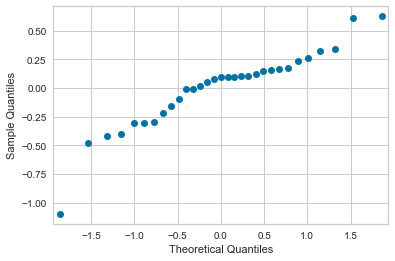

In [97]:
res = results.resid 
fig = sm.qqplot(res)
plt.show()

#### Plot Residuals Plot

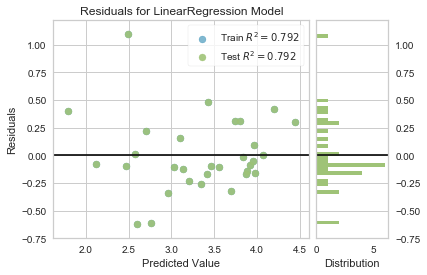

In [98]:
# Instantiate the linear model and visualizer
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X, y)  # Fit the training data to the model
visualizer.score(X, y)  # Evaluate the model on the test data
visualizer.poof()               

### Problem 1d 

Describe in what way the model diagnostics are appropriate or not.  Be specific.

### Problem 1e

Using your knowledge of statistics, what would you conclude about climate change?

## Problem 2  Matrix model for regression (8 points)

### Problem 2a  
Using the features that you deemed important in Problem 1, construct the matrix forms of the appropriate variables.  Specifically you will need a matrix X that has the features used in your solution and a Y = logTemp.  Print the head of each of these.

In [99]:
print('''
X and y have been processed already.
''')
# # respecify X columns dropping IceShelf
# X_cols = ['CO2', 'Solar', 'Transmission']
# X, y = gw[X_cols], gw['log_temp']

# # fill mean for Transmission missin gvalue
# not_missing = ~gw.Transmission.isnull()
# X.loc[~not_missing, 'Transmission'] = X.loc[not_missing, 'Transmission'].mean()

# # scale with standard scaler & add constant
# X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns.tolist())
# X = sm.add_constant(X)
# #X = X.stack()

# y = y.ravel(-1)

print('X: \n', X.head(), '\n')
print('y: \n', y[:5])


X and y have been processed already.

X: 
    const       CO2  Transmission  CO2 Solar  Solar Transmission     Solar
0    1.0 -1.579838      0.446017  -1.575164            0.469142  1.545449
1    1.0 -1.487757      0.451212  -1.482695            0.474354  1.545449
2    1.0 -1.393629     -3.533328  -1.394159           -3.534160  0.667996
3    1.0 -1.297456     -1.213775  -1.297261           -1.207191  0.718136
4    1.0 -1.193097     -0.238420  -1.200598           -0.245418 -0.460157 

y: 
 Year
1980    2.944439
1981    3.258097
1982    1.386294
1983    3.218876
1984    2.197225
Name: log_temp, dtype: float64


### Problem 2b  
Use the matrix calculation for the pseudo-inverse provided in lecture.  

```
From Lecture Notes:
 SSE = (YTY - 2YTXW + WTXTXW) 
 How to minimize this?
 Derivative wrt W and set to 0
 d/dW
 0–2XTY+2XTXW=0
◦ Note that d/dW of UTVW = VTU
◦ Last term with the W’s on either side is a quadratic which yields 2 and removal of WT
◦ XTXW = XTY 
 W = (XTX)-1XTY
◦ (XTX)-1XT is the Moore-Penrose
Pseudoinverse of X
 Why can’t we just do an inverse of X?
```

In [104]:
W = np.dot(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, y.values.reshape(-1)))
print('Model coefficients')
pd.Series(W, index=signif_X)

Model coefficients


const                    3.338310
CO2                    248.225436
Transmission          2341.300786
CO2 Solar             -246.835955
Solar Transmission   -2334.224694
Solar                   34.900826
dtype: float64

``` 
 Least Squares Estimate
 SSE = eTe
◦ Is this an inner product or outer product?
 e = Y-XW
 SSE = (Y-XW)T(Y-XW)
 SSE = (YT-WTXT) (Y-XW) 
◦ Note that (AB) T = BTAT
 SSE = (YTY – WTXTY + WTXTXW - YTXW)
 ◦ The 2nd and 4th term are equivalent 
 Not obvious from the matrix format
 True when you multiply them out

 Least Squares Estimate
 SSE = (YTY - 2YTXW + WTXTXW) 
 How to minimize this?
 Derivative wrt W and set to 0
d/dW
 0–2XTY+2XTXW=0
◦ Note that d/dW of UTVW = VTU
◦ Last term with the W’s on either side is a quadratic which yields 2 and removal of WT
◦ XTXW = XTY 
 W = (XTX)-1XTY
◦ (XTX)-1XT is the Moore-Penrose
Pseudoinverse of X
 Why can’t we just do an inverse of X?
```

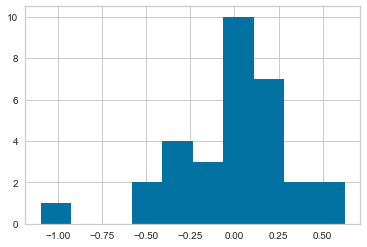

In [106]:
# view errors
y_hat = np.dot(X, W)
e = y - y_hat
e.hist()

#### Observe `r2_score`

In [107]:
r2_score(y, y_hat)

0.792261177152638

```
#from the matrix method 
#array([3.33830955, 0.57090132, 0.21981988, 0.23461582])

#from sm.OLS
#Parameters: 
# const    3.337343
# x1       0.585765
# x2       0.230771
# x3       0.238898
# dtype: float64 
```

## Problem 2c
How does the answer in Problem 2b compare to that of 1b?

Model coefficients from `statsmodels` approach:

```
const                    3.338310
CO2                    248.225444
Transmission          2341.300603
CO2 Solar             -246.835963
Solar Transmission   -2334.224511
Solar                   34.900824
```

Model coefficients from Matrix form:

```
const                    3.338310
CO2                    248.225436
Transmission          2341.300786
CO2 Solar             -246.835955
Solar Transmission   -2334.224694
Solar                   34.900826
```

## Problem 3 Time Series Modeling (40 points)

Use the data timeSeries4.csv for this problem. The data are monthly reports of production.

### Problem 3a
Plot the data and perform an exploratory analysis on the raw time series file. Comment on any trends, outliers, seasonality, whether it's stationary, etc.

#### Read in Time Series Data

In [108]:
ts_df = pd.read_csv('data/timeSeries4.csv', header=None)
ts_df.set_index(0, inplace=True) 
ts_df.head()

,1
0,
0,21.684748
1,21.622112
2,19.583297
3,23.290602
4,21.729621


#### Describe Dataset & Check Missing Values

In [109]:
ts_df.describe().T

,count,mean,std,min,25%,50%,75%,max
1,148.0,24.529022,2.648555,10.521345,22.811038,24.536239,26.703908,29.68814


In [106]:
ts_df.isnull().sum()

1    0
dtype: int64

#### Plot TIme Series with 5 Period Moving Average

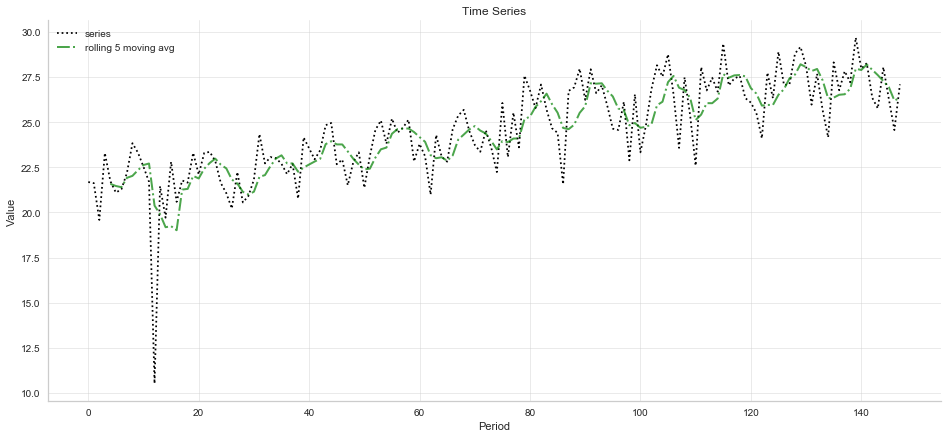

In [110]:
import seaborn as sns
def set_mpl_preferences(ax):
    ax.grid(alpha=.4)
    sns.despine()

fig, ax = plt.subplots(figsize=(16, 7))
ts_df[1].plot(ax=ax, linestyle=':', color='black', label='series')
set_mpl_preferences(ax)
ax.set_title('Time Series')
ax.set_xlabel('Period')
ax.set_ylabel('Value')
ax.plot(ts_df[1].rolling(5).mean(), linestyle='-.', color='green', alpha=.7, linewidth=2, label='rolling 5 moving avg')
ax.legend(loc='best')

#### Plot Histogram

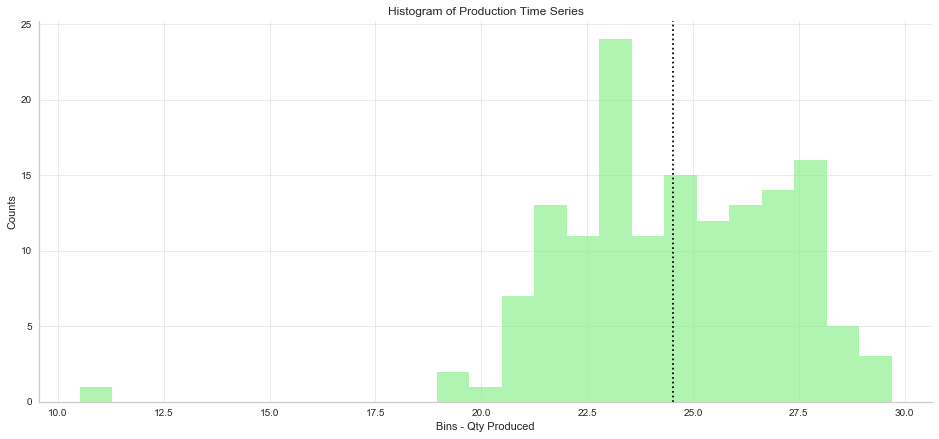

In [109]:
fig, ax = plt.subplots(figsize=(16, 7))
ts_df.hist(ax=ax, alpha=.7, color='lightgreen', bins=25)
set_mpl_preferences(ax)
ax.set_title('Histogram of Production Time Series')
ax.set_xlabel('Bins - Qty Produced')
ax.set_ylabel('Counts')
ax.axvline(ts_df[1].mean(), linestyle=':', color='black', label='mean')

#### Add months to index to enable plotting functions

In [112]:
ts_df.index = pd.date_range(start='01/01/2005', periods=ts_df.shape[0], freq='M')

#### Plot `breakout` Plots `seasonal_decompose`

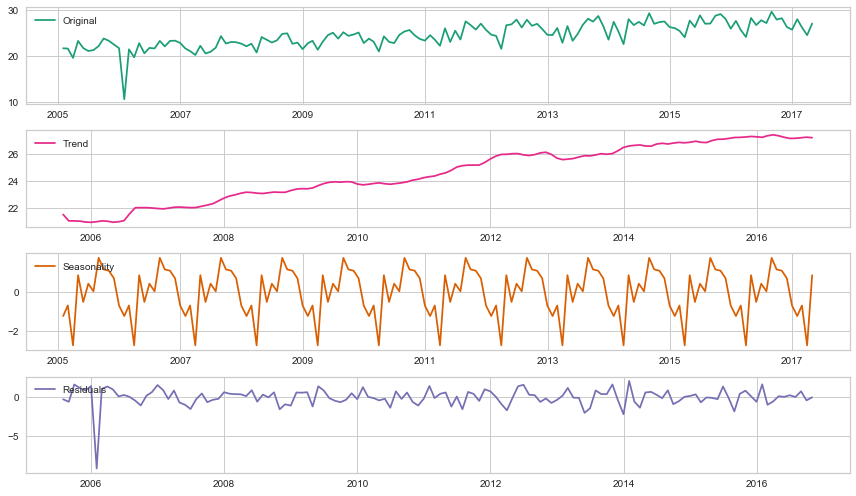

In [113]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.colors import ListedColormap

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a'])
dark2_cmap=ListedColormap(dark2_colors)

def breakout_plots(seas_series):
    decomposition = seasonal_decompose(seas_series) 

    f, ax = plt.subplots(1,4,figsize=(12, 7))

    plt.subplot(411)
    plt.plot(seas_series, label='Original', c=dark2_colors[0])
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', c=dark2_colors[1])
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(decomposition.seasonal,label='Seasonality', c=dark2_colors[2])
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals', c=dark2_colors[3])
    plt.legend(loc='upper left')
    plt.tight_layout()
    
    return decomposition

decomposition = breakout_plots(ts_df[1])

#### Plot `tsplot` on the Raw Data

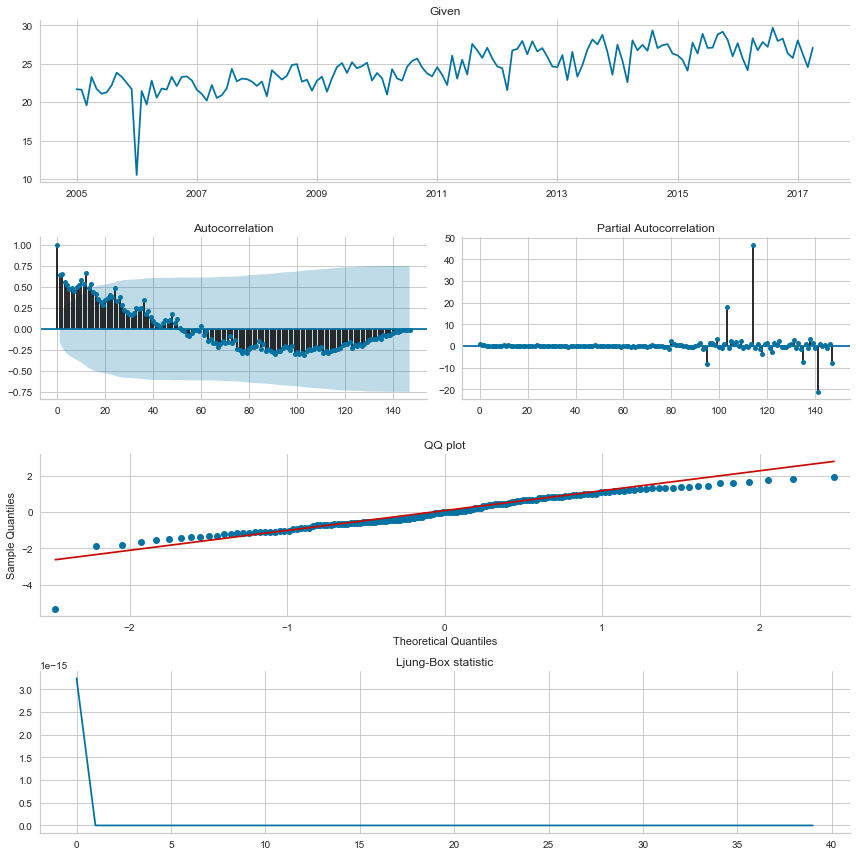

In [115]:
def tsplot(y, lags=None, figsize=(12, 12)):
    
    q, p = sm.stats.diagnostic.acorr_ljungbox(y,lags)
    fig = plt.figure(figsize=figsize)
    layout = (4, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0), colspan=2, title='QQ plot')
    lbox_ax = plt.subplot2grid(layout, (3, 0), colspan=2, title='Ljung-Box statistic')

    y.plot(ax=ts_ax, title='Given')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

    qqplot(y,  line='q', ax=qq_ax, fit=True)
    if np.max(p) > 0.05:
        lbox_ax.axhline(y=0.05, xmin=0, xmax=lags, c ='r')
    lbox_ax.plot(p)
    sns.despine()
    plt.tight_layout()
    plt.show()
    return ts_ax, acf_ax, pacf_ax, lbox_ax

_ = tsplot(ts_df[1])

#### Perform Same Plot on Residuals

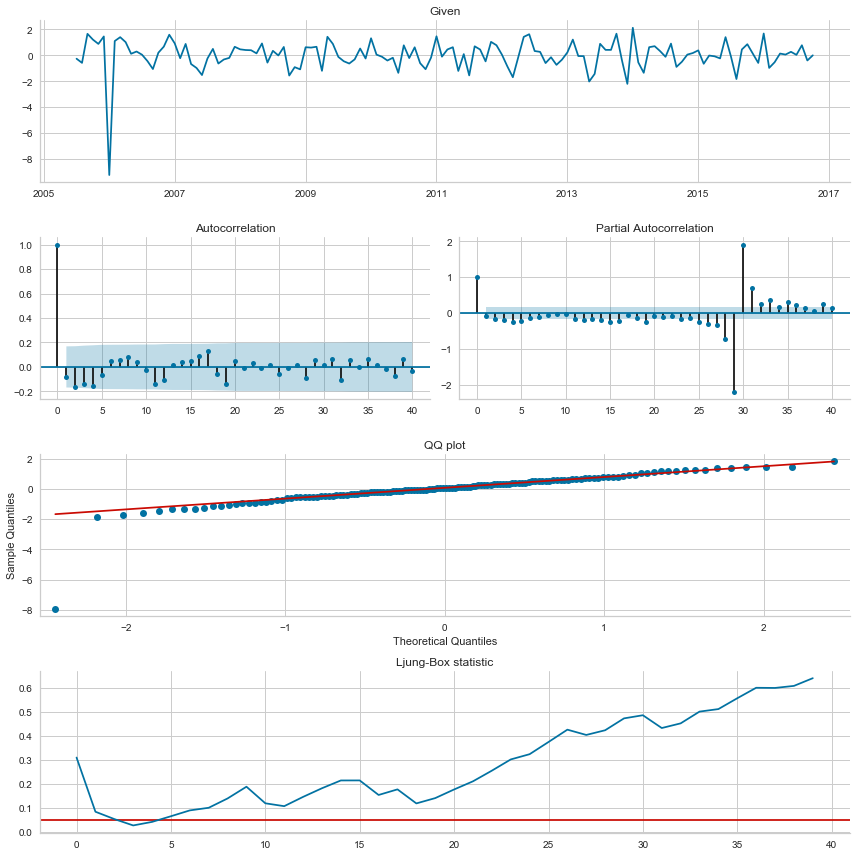

In [116]:
decomp_resid = decomposition.resid
decomp_resid.dropna(inplace=True)
_ = tsplot(decomp_resid, 40)

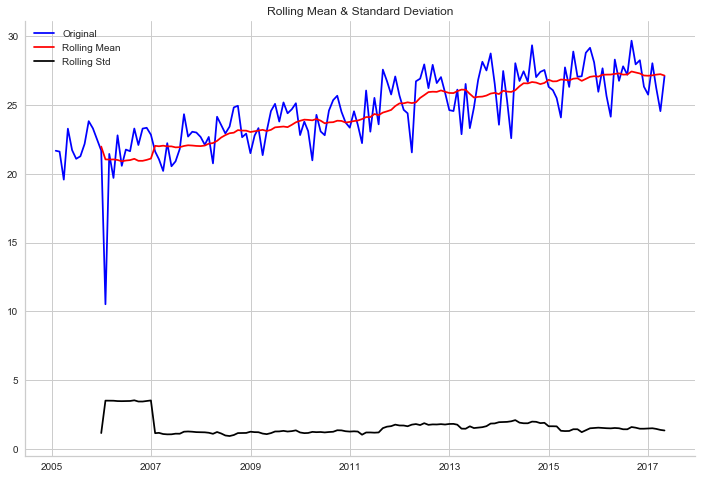

Results of Dickey-Fuller Test:
Test Statistic                  -1.593535
p-value                          0.486840
#Lags Used                      13.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64


In [125]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()#pd.rolling_mean(timeseries, window=12)
    rolstd = timeseries.rolling(12).std()#pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    sns.despine()
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 
    
test_stationarity(ts_df[1])

The data is not stationary and there is a clear upward trend.  This is evident by simply looking at the data -- but is also evident via the Dickey-Fuller test. There also appears to be very consistent seasonality, as evidenced by the `breakout` plot.  There does appear to be one outlier

### Problem 3b
Using your knowledge of ACF, PACF and other diagnostics, walk us through the selection of an appropriate time series model for the data.  We are interested in both the result and your logical journey to reach that model.  That journey should begin with observations from the ACF and PACF pattern.

#### Fit Baseline Model Without Differencing

                           Statespace Model Results                           
Dep. Variable:                      1   No. Observations:                  148
Model:                        SARIMAX   Log Likelihood                -353.655
Date:                Mon, 22 Oct 2018   AIC                            711.311
Time:                        13:11:54   BIC                            717.305
Sample:                    01-31-2005   HQIC                           713.746
                         - 04-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     24.5290      0.233    105.145      0.000      24.072      24.986
sigma2         6.9674      0.515     13.521      0.000       5.957       7.977
Ljung-Box (Q):                     1085.33   Jarque-

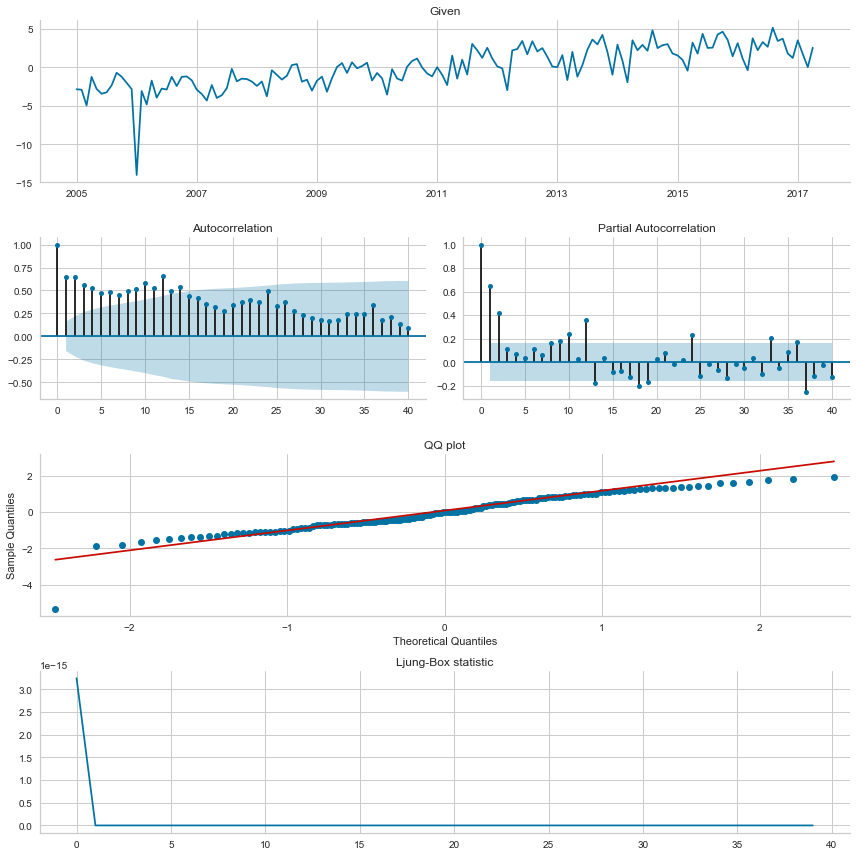

In [147]:
# arima model
mod = sm.tsa.statespace.SARIMAX(ts_df[1], 
                                trend='c', 
                                freq='M', 
                                order=(0,0,0), 
                                #seasonal_order=(0,0,1,1), 
                                simple_differencing=True)

results_ARIMA = mod.fit(disp=False)
print(results_ARIMA.summary())

print('\n\nResiduals\n\n')
_ = tsplot(results_ARIMA.resid, 40)

```
(p, d, q):
* p: auto-regressive part (warm today if warm past 3 days)
* d: integrated part (amount of differencing)
* q: moving avg part 

(1,0,1),(1,1,1,12) AIC: 488.4 BIC: 505.9
(1,0,1),(0,1,1,12) AIC: 491.4 BIC: 506.0
(1,0,1),(0,1,1,12) AIC: 491.4 BIC: 506.0
```

In [186]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [187]:
# method borrowed from 
# https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_df[1],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1361.8456189911835
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1111.2358685124532
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:525.4660874804665
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:433.5111180620322
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:563.2982781926123
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:485.6803207030412
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:462.1472787887035
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:434.23188764919865
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1185.6624641022986
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:950.4363375102946
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:518.2417104633133
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:417.29502800149066
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:562.6174747290722
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:486.0913645881453
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:447.61620141295055
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:416.7505241907508
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:650.3240731342158
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:525.0172662929823
ARIM

It appears that the model with the parameters `ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:389.20187413724904` performed the best in our grid search, so we will employ this one.

                                 Statespace Model Results                                 
Dep. Variable:                                  1   No. Observations:                  148
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -190.696
Date:                            Mon, 22 Oct 2018   AIC                            389.392
Time:                                    14:36:09   BIC                            400.575
Sample:                                01-31-2005   HQIC                           393.934
                                     - 04-30-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0029      0.003     -1.032      0.302      -0.009       0.003
ma.L1         -1.0000    188.298   

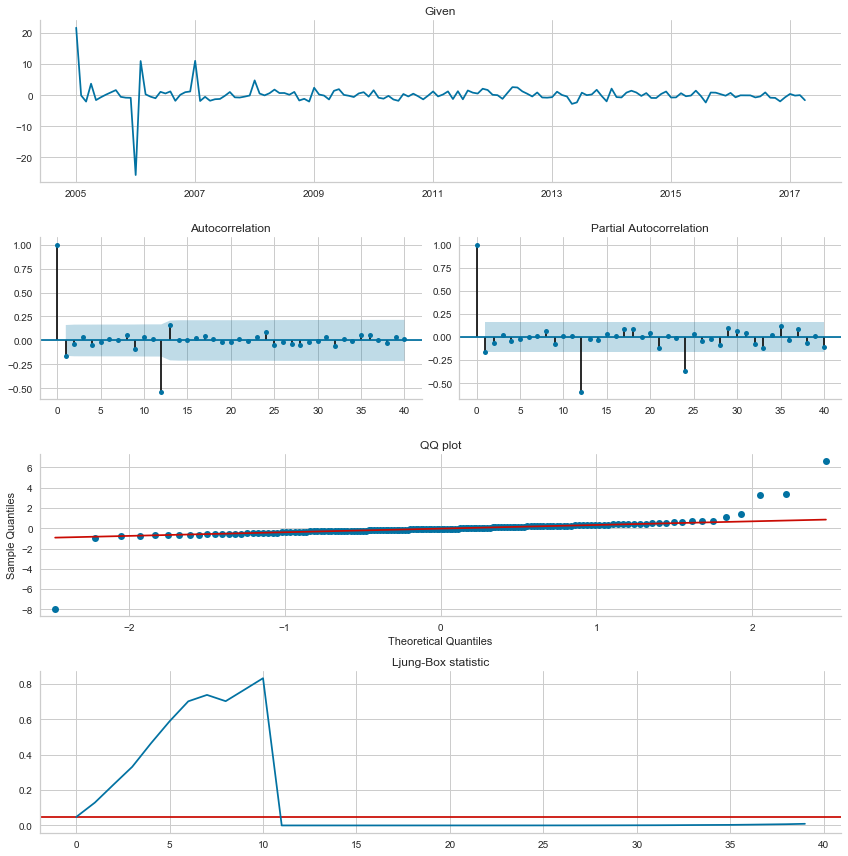

In [198]:
# arima model
mod = sm.tsa.statespace.SARIMAX(ts_df[1], 
                                trend='c', 
                                freq='M', 
                                order=(0,1,1), 
                                seasonal_order=(0,1,1,12),#(0,0,1,1), 
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_ARIMA = mod.fit(disp=False)
print(results_ARIMA.summary())

print('\n\nResiduals\n\n')
_ = tsplot(results_ARIMA.resid, 40)

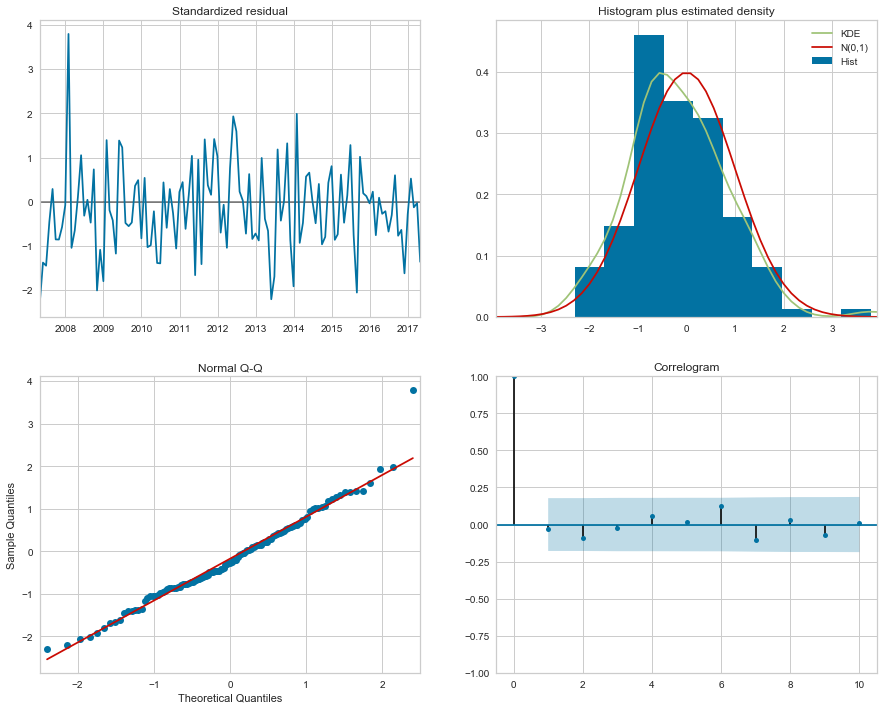

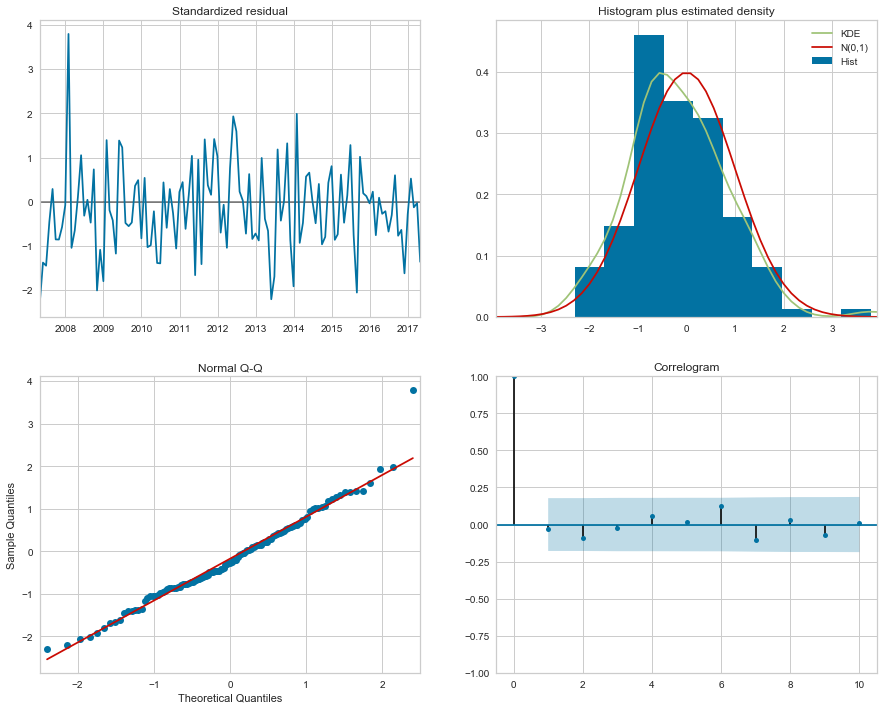

In [197]:
results.plot_diagnostics(figsize=(15, 12))

In [199]:
ts_df.tail()

,1
2016-12-31,25.762907
2017-01-31,28.048425
2017-02-28,26.271352
2017-03-31,24.563050
2017-04-30,27.093731


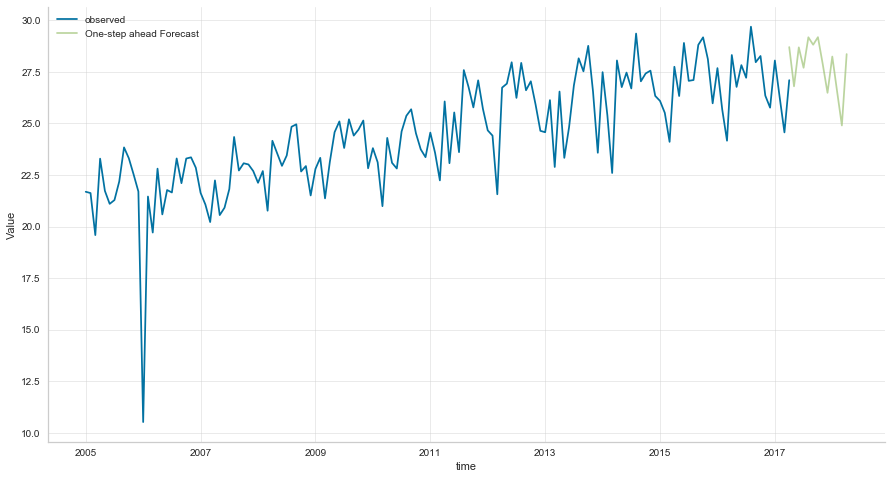

In [205]:
pred = results.get_prediction(start=pd.to_datetime('2017-04-30'), 
                              end=pd.to_datetime('2018-04-30'), dynamic=False)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(15, 8))
ts_df[1].plot(label='observed', ax=ax)
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
set_mpl_preferences(ax)

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('time')
ax.set_ylabel('Value')
plt.legend()

plt.show()

### Problem 3c
Apply and show the appropriate diagnostics to the model to assert that it is valid.  Include not just a plot but your interpretation of the plot in your justification.

## Problem 4 (15 points)

For a time series data set, a (2,1,1) was derived with the following coefficients:

const   -0.3916      
ar1      0.9172      
ar2     -0.2390      
ma1      0.4012      

The last 5 points are -104.6, -102.1, -103.2, -109.8, -115.7

Compute the next 3 data points by writing the calculation in python.  Note that this will require not only plugging values into the equation, but also taking the d term of the (p,d,q) ARIMA model into account.  We do not need a general form or function--just the required calculations.

In [136]:
X = pd.Series([-104.6, -102.1, -103.2, -109.8, -115.7])
X

0   -104.6
1   -102.1
2   -103.2
3   -109.8
4   -115.7
dtype: float64

In [138]:
X_diff = X.diff()
X_diff

0    NaN
1    2.5
2   -1.1
3   -6.6
4   -5.9
dtype: float64

In [139]:
coefs = dict(const=-0.3916,
             ar1=0.9172,
             ar2=-0.2390,
             ma1=0.4012)

params = dict(p=2, d=1, q=1)

In [144]:
X.mean() + coefs['const'] + coefs['ar1']*X_diff[4] + coefs['ar2']*X_diff[3] + coefs['ma1']*X_diff[4]

-113.67276000000001

In [142]:
X.mean()

-107.08

In [145]:
from statsmodels.tsa.arima_model import ARIMA
arima = ARIMA(X, order=(2, 1, 1))
arima_summary = arima.fit()
arima_summary.summary()

ValueError: Insufficient degrees of freedom to estimate

In [146]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array-like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array-like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array-like of datetime, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes
 |  -----
 |  If exogenous variables are given, then the model that is fit is
 

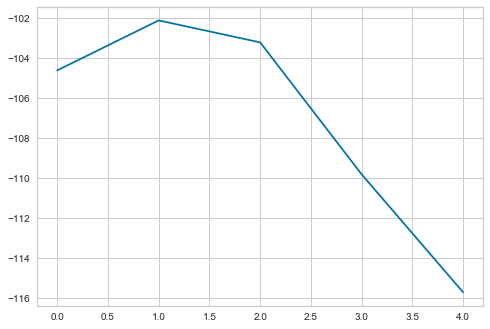

In [121]:
X = pd.Series([-104.6, -102.1, -103.2, -109.8, -115.7])
X.plot()

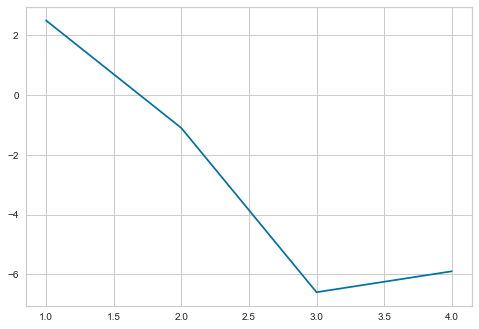

In [124]:
X.diff().plot()

In [ ]:
# from statsmodels.tsa.arima_model import ARIMA

# ARIMA(p, order=(5,1,0))

In [ ]:
def predict_next(p, d, q):
    

## Problem 5 (2 points)
How many hours did this homework take you?  The answer to this question will not affect your grade.

## Last step (5 points)

Save this notebook as LastnameFirstnameHW3.ipynb such as BradyTom.ipynb. Create a pdf of this notebook named similarly. Submit both the python notebook and the pdf version to the Canvas dropbox. We require both versions.